<a href="https://colab.research.google.com/github/adithyabalakumar/EVA-4/blob/master/S6/With%20L2/With_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/S6/With L2/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/S6/With L2


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 24

       # self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 22

        # TRANSITION BLOCK 1
        
        self.convblock4 = nn.Sequential(
            nn.MaxPool2d(2, 2) ,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         )  #output_size = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 7

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 3
         
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             576
      BatchNorm2d-10            [-1, 8, 22, 22]              16
          Dropout-11            [-1, 8, 22, 22]               0
             ReLU-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11430090665817261 Batch_id=468 Accuracy=90.56: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9855/10000 (98.55%)

EPOCH: 1


Loss=0.042222846299409866 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9899/10000 (98.99%)

EPOCH: 2


Loss=0.02941957674920559 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9918/10000 (99.18%)

EPOCH: 3


Loss=0.09581786394119263 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.05076487362384796 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9927/10000 (99.27%)

EPOCH: 5


Loss=0.021476328372955322 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.038701578974723816 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.03968710079789162 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.009991630911827087 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.05060987174510956 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.015679432079195976 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.0717608705163002 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.038474440574645996 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.024448402225971222 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.01329562533646822 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9947/10000 (99.47%)

EPOCH: 15


Loss=0.011824126355350018 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.03771702200174332 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.047816868871450424 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.02291817218065262 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


Loss=0.02081294171512127 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.029774239286780357 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.054728150367736816 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.05134454369544983 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.03490858152508736 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.015819059684872627 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9949/10000 (99.49%)

EPOCH: 25


Loss=0.027860581874847412 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.016385717317461967 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 41.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9936/10000 (99.36%)

EPOCH: 27


Loss=0.02913053147494793 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9938/10000 (99.38%)

EPOCH: 28


Loss=0.022032447159290314 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 29


Loss=0.05789043381810188 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.03762653097510338 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 39.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9939/10000 (99.39%)

EPOCH: 31


Loss=0.012404873967170715 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.04257075861096382 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9948/10000 (99.48%)

EPOCH: 33


Loss=0.04952605068683624 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9922/10000 (99.22%)

EPOCH: 34


Loss=0.058218371123075485 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9944/10000 (99.44%)

EPOCH: 35


Loss=0.03407558426260948 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 39.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.012700080871582031 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 40.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9944/10000 (99.44%)

EPOCH: 37


Loss=0.02247249148786068 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.04951794072985649 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 39


Loss=0.02006855607032776 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]



Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)



In [0]:
import pickle

pickle_file_path = "/content/gdrive/My Drive/Colab Notebooks/S6/With L2/with L2.pickle"
pickle_obj = {"test_accuracy": test_acc, "test_loss": test_losses}

with open(pickle_file_path, 'wb') as f:
  pickle.dump(pickle_obj, f)
  print("Test accuracy and loss write completed!")

Test accuracy and loss write completed!


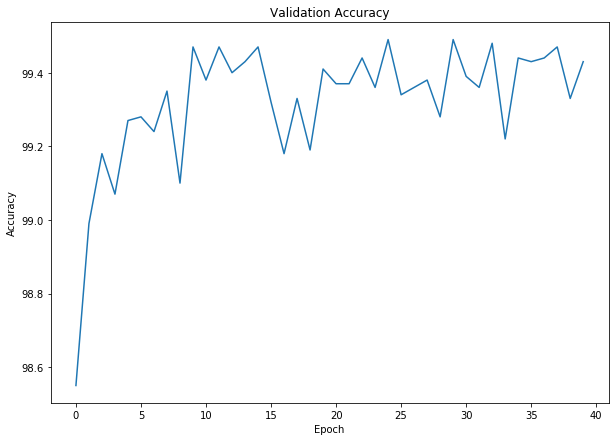

In [0]:
import matplotlib.pyplot as plt

val_acc_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test accuracy plot
axs.plot(test_acc)
axs.set_title("Validation Accuracy")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
val_acc_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/With L2/validation_accuracy.jpg')

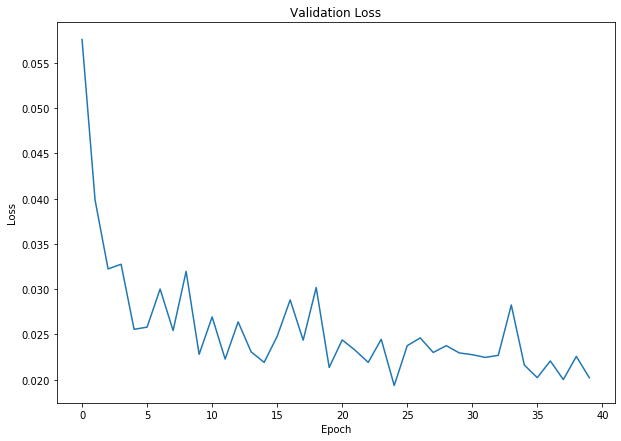

In [0]:
val_loss_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test loss plot
axs.plot(test_losses)
axs.set_title("Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
val_loss_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/With L2/validation_loss.jpg')

**Misclassified** **Images**

In [0]:
import numpy as np

from google.colab import files

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count == 25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig("/content/gdrive/My Drive/Colab Notebooks/S6/With L2/Misclassified Images/image_" + str(count)+".jpg")
                plt.close(fig)
                count += 1